In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import  Embedding,RNN
import string
%matplotlib inline

Using TensorFlow backend.


In [2]:
#function to read the Text file
def read_text(filename):
        file = open(filename, mode='rt', encoding='utf-8')
        text = file.read()
        file.close()
        return text


In [3]:
#function to convert the text to sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = np.array(deu_eng)

In [5]:
deu_eng=deu_eng[:,0:2] #slice the sentence till german and ignore attribution 

In [6]:
deu_eng=deu_eng[:5000] # read the first 5000 examples

In [7]:
#text cleaning
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [8]:
#convert all words to lower case
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng


array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['youre right', 'ihr habt recht'],
       ['youre right', 'sie haben recht'],
       ['youre sharp', 'du bist scharfsinnig']], dtype='<U537')

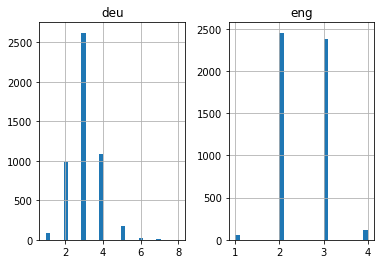

In [9]:
import pandas as pd
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [10]:
print('Maximum length of German phrase :',str(np.array(deu_l).max()))
print('Maximum length of English phrase :',str(np.array(eng_l).max()))

Maximum length of German phrase : 8
Maximum length of English phrase : 4


In [11]:
#Tokenization of phrases and converting to sequence of numbers
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [12]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = np.array(eng_l).max()
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 1309


In [13]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = np.array(eng_l).max()
print('Deutch Vocabulary Size: %d' % deu_vocab_size)


Deutch Vocabulary Size: 2225


In [14]:
# function to get word through index
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [15]:
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [17]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)


In [18]:
#encoding dataset
trainY = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [19]:
testY = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [20]:
#Using Glove For making word embedding for respresenting input sequence
embeddings_index = dict()
f = open('glove.6B.50d.txt',encoding="utf8")
for line in f:
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [21]:
#getting embedding matrix for the entire vocabulary
embedding_matrix = np.zeros((eng_vocab_size, 50))
for word, i in eng_tokenizer.word_index.items():
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
     embedding_matrix[i] = embedding_vector

In [22]:
#converting the input sequence into embedding and reshaping a 3D tensor of shape(Embedding dim,Number of sample,Timestep)
Embed_encoder_train=np.zeros((trainX.shape[0],50,eng_length))
for m in range(trainX.shape[0]):
    for t in range(eng_length):
        Embed_encoder_train[m,:,t]=embedding_matrix[trainX[m,t]]
Embed_encoder_test=np.zeros((testX.shape[0],50,eng_length))
for m in range(testX.shape[0]):
    for t in range(eng_length):
        Embed_encoder_test[m,:,t]=embedding_matrix[testX[m,t]]

In [23]:
Embed_encoder_train=Embed_encoder_train.reshape(Embed_encoder_train.shape[1],Embed_encoder_train.shape[0],Embed_encoder_train.shape[-1])
Embed_encoder_test=Embed_encoder_test.reshape(Embed_encoder_test.shape[1],Embed_encoder_test.shape[0],Embed_encoder_test.shape[-1])

Embed_encoder_train.shape

(50, 4000, 4)

In [24]:
from Layer import RNN
import train

In [25]:
#initialising RNN
r=RNN(Embed_encoder_train,eng_vocab_size,deu_vocab_size,10,1e-3,32,50,eng_length)

In [26]:
train.fit(trainX,trainY,r) # fit the model

loss:  23.333111585354914
loss:  23.21327109501647
loss:  23.103786784339015
loss:  22.982578849835903
loss:  22.868665549685794
loss:  22.75332602009702
loss:  22.638859268948803
loss:  22.523858213170648
loss:  22.409927021734536
loss:  22.297307244370707
weights saved successfully


In [27]:
Y_pred_train=train.predict(trainX,trainY,Embed_encoder_train) #training error

22.18603860877963


In [28]:
Y_pred_test=train.predict(testX,testY,Embed_encoder_test) #predicting for test set

22.16183736533102
